In [1]:
from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import os
import pickle
import time
import pandas as pd

/home/luqman/.local/share/virtualenvs/ME-GraphAU-NHAhuV8b/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# bbox has 4 elements, 1st and 2nd elements are top left x,y coordinates 
# 3rd and 4th elements are top bottom x,y coordinates
def show_img(img_path, bbox):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    cv_img = np.array(img)
    x1 = int(bbox[0])
    y1 = int(bbox[1])
    x2 = int(bbox[2])
    y2 = int(bbox[3])
    cv2.rectangle(cv_img, (x1, y1), (x2, y2), (0,255,0), 3)
    plt.imshow(cv_img)
    plt.show()

# Test on a single image

In [6]:
img_path = "/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/frames/SN001/1.png"
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
frame = Image.fromarray(img)
mtcnn = MTCNN(keep_all=True, device='cuda:0')
boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)

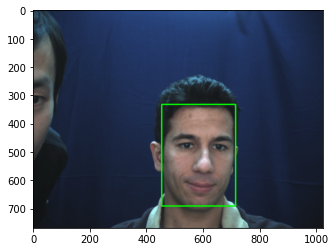

In [9]:
show_img(img_path, boxes[0])

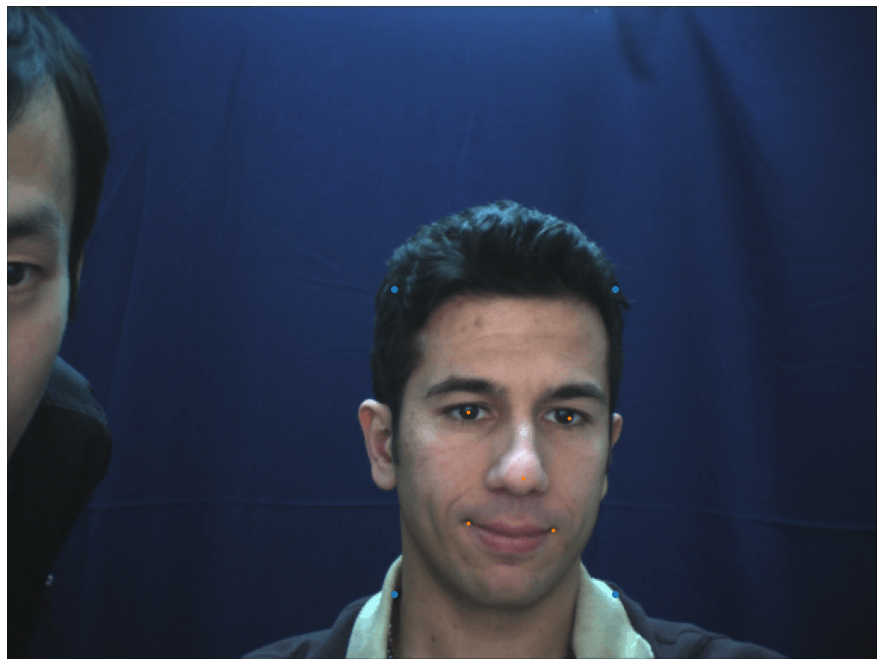

In [10]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(frame)
ax.axis('off')

for box, landmark in zip(boxes, landmarks):
    ax.scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]))
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8)
fig.show()

# Run MTCNN on BP4D

In [32]:
start_time = time.time()
video_names = ['F001','M007','F018','F008','F002','M004','F010','F009','M012','M001','F016','M014',
                'F023','M008','M011','F003','M010','M002','F005','F022','M018','M017','F013','M016',
                'F020','F011','M013','M005','F007','F015','F006','F019','M006','M009','F012','M003',
                'F004','F021','F017','M015','F014']
tasks = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8']
labels_dir = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/BP4D/AU_labels'
input_dir = "/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/BP4D/img_raw"
batch_size = 32
mtcnn = MTCNN(keep_all=True, device='cuda:0')

for video_name in video_names:
    print(f'Processing {video_name}')
    
    for task in tasks:
        label_filename = video_name + "_" + task + ".csv"
        label_path = os.path.join(labels_dir, label_filename)
        label_df = pd.read_csv(label_path, header=0, index_col=0, usecols=[0])
        
        frames_idx = []
        frames = []
        boxes = []
        landmarks = []
        probs = []
        img_dir = os.path.join(input_dir, video_name, task)
        files_count = len(label_df)
        counter = 0
    
        for idx, row in label_df.iterrows():
            counter += 1
            filename = str(idx-1) + '.jpg'
            img_path = os.path.join(img_dir, filename)
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(img)
            frames.append(frame)
            frames_idx.append(idx)

            if (len(frames) == batch_size or counter == files_count):
                batch_boxes, batch_probs, batch_landmarks = mtcnn.detect(frames, landmarks=True)
                boxes.extend(batch_boxes)
                landmarks.extend(batch_landmarks)
                probs.extend(batch_probs)
                frames = []
    
        output = {'frames_idx': frames_idx, 'boxes': boxes, 'probs': probs, 'landmarks': landmarks}
        out_filename = video_name + "_" + task + ".pickle"
        out_path = os.path.join('/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/BP4D/mtcnn', out_filename)
        outfile = open(out_path, 'wb')
        pickle.dump(output, outfile)
        outfile.close()
        print(f'Output is saved on {out_path}')
        break
    break
  
print("--- %s seconds ---" % (time.time() - start_time))

Processing F001
Output is saved on /nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/BP4D/mtcnn/F001_T1.pickle
--- 37.51046133041382 seconds ---


# Crop image

In [3]:
def rescale_box(box, scale):
    w = box[2] - box[0]
    h = box[3] - box[1]
    cx = box[0] + int(w/2)
    cy = box[1] + int(h/2)
    max_len = max(w, h)
    new_w = int(max_len * scale / 2)
    x1 = cx - new_w
    y1 = cy - new_w
    x2 = cx + new_w
    y2 = cy + new_w
    new_box = [x1,y1,x2,y2]
    return new_box

# crop image and resize to 224x224
def crop_img(img_path, coords, out_path):
    image_obj = Image.open(img_path)
    cropped_image = image_obj.crop(coords)
    img = cropped_image.resize((224,224))
    img.save(out_path)

In [ ]:
start_time = time.time()
video_names = ['SN009']

box_path = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/mtcnn'
input_dir = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/frames'
output_path = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/img'

for d in os.listdir(DIR):
    f_path = box_path + "/" + v + ".pickle"
    boxes = pickle.load(open(f_path, "rb"))
    img_dir = os.path.join(input_dir, v)
    
    out_dir = os.path.join(output_path, v)
    os.makedirs(out_dir, exist_ok=True)
    
    for i, box in enumerate(boxes):
        in_filename = str(i+1) + ".png"
        img_path = os.path.join(img_dir, in_filename)
        out_filename = str(i) + ".png"
        out_img_path = os.path.join(out_dir, out_filename)
        
        if (box is None):
            command = "cp " + img_path + " " + out_img_path  
            os.system(command)
        else:
            s_box = rescale_box(box[0], 1.3)
            crop_img(img_path, s_box, out_img_path)
            
print("--- %s seconds ---" % (time.time() - start_time))

# Delete broken frames

In [6]:
path = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/img/SN009'

for i in range(1740, 1767):
    filename = str(i) + '.png'
    img_path = os.path.join(path, filename)
    command = "rm " + img_path
    os.system(command)

# Rename frames

In [14]:
path = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/DISFA/img_align/SN009'

for i in range(1767, 4845):
    filename = str(i) + '.png'
    img_path = os.path.join(path, filename)
    new_filename = str(i-27) + '.png'
    new_img_path = os.path.join(path, new_filename)
    command = "mv " + img_path + " " + new_img_path
    os.system(command)
print("Done")

Done


# Face alignment

In [2]:
from face_alignment import face_alignment

In [3]:
img_path = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/BP4D/img_raw/M009/T4/744.jpg'
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
frame = Image.fromarray(img)
mtcnn = MTCNN(keep_all=True, device='cuda:0')
boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)

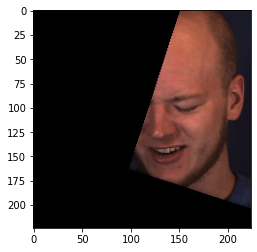

In [4]:
aligned_img = face_alignment(img, landmarks[0])
plt.imshow(aligned_img)
plt.show()

## Run face alignment on BP4D

Processing F001
/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/BP4D/img/F001/T1/2440.jpg


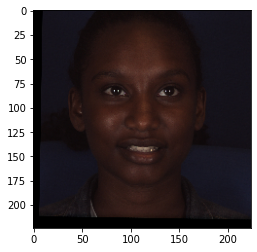

--- 0.3154308795928955 seconds ---


In [14]:
start_time = time.time()
video_names = ['F001','M007','F018','F008','F002','M004','F010','F009','M012','M001','F016','M014',
                'F023','M008','M011','F003','M010','M002','F005','F022','M018','M017','F013','M016',
                'F020','F011','M013','M005','F007','F015','F006','F019','M006','M009','F012','M003',
                'F004','F021','F017','M015','F014']
tasks = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8']
input_dir = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/BP4D/img_raw'
mtcnn_output_dir = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/BP4D/mtcnn_out'
output_path = '/nas/project_data/B1_Behavior/hakim/ME-GraphAU/data/BP4D/img'

for video_name in video_names:
    print(f'Processing {video_name}')
    
    for task in tasks:
        img_dir = os.path.join(input_dir, video_name, task)
        out_dir = os.path.join(output_path, video_name, task)
        os.makedirs(out_dir, exist_ok=True)
        mtcnn_output_file = mtcnn_output_dir + "/" + video_name + "_" + task + ".pickle"
        mtcnn_output = pickle.load(open(mtcnn_output_file, "rb"))
    
        for i, frame_idx in enumerate(mtcnn_output['frames_idx']):
            in_filename = str(frame_idx-1) + ".jpg"
            in_img_path = os.path.join(img_dir, in_filename)
            out_filename = str(frame_idx) + ".jpg"
            out_img_path = os.path.join(out_dir, out_filename)
            print(out_img_path)
                
            if (mtcnn_output['landmarks'][i] is None):
                print(f'NO FACE DETECTION - {in_img_path}')
                continue
            else:
                
                landmark = mtcnn_output['landmarks'][i][0]        
                img = cv2.cvtColor(cv2.imread(in_img_path), cv2.COLOR_BGR2RGB)
                aligned_img = face_alignment(img, landmark)
                img = Image.fromarray(aligned_img)
#                 img.save(out_img_path)

                plt.imshow(aligned_img)
                plt.show()
        
            break
        break
    break

print("--- %s seconds ---" % (time.time() - start_time))